# Predicting NFL Game Outcomes
## Rohan Lewis, Michael Nercessian, Matthew Armstrong

# 2019 NFL Game by Game Data

We first manually downloaded our data from this source: https://www.pro-football-reference.com/teams/

Our first step will be to import all of the modules we need, and then load the data.

In [1]:
# import Pkg
# Pkg.add("CSV")
# Pkg.add("Plots")
# Pkg.add("DataFrames")
# Pkg.add("Statistics")

In [2]:
using Random
using CSV
using Plots
using DataFrames
using Statistics

In [72]:
nfl_teams = CSV.read("Datasets/nfl_teams.csv")
nfl_teams_with_spaces = CSV.read("Datasets/nfl_teams_with_spaces.csv")
showall(nfl_teams_with_spaces)

32×5 DataFrame
│ Row │ ID    │ Name                 │ Abbreviation │ Conference │ Division │
│     │ Int64 │ String               │ String       │ String     │ String   │
├─────┼───────┼──────────────────────┼──────────────┼────────────┼──────────┤
│ 1   │ 1     │ Arizona Cardinals    │ ARI          │ NFC        │ West     │
│ 2   │ 2     │ Atlanta Falcons      │ ATL          │ NFC        │ South    │
│ 3   │ 3     │ Baltimore Ravens     │ BAL          │ AFC        │ North    │
│ 4   │ 4     │ Buffalo Bills        │ BUF          │ AFC        │ East     │
│ 5   │ 5     │ Carolina Panthers    │ CAR          │ NFC        │ South    │
│ 6   │ 6     │ Chicago Bears        │ CHI          │ NFC        │ North    │
│ 7   │ 7     │ Cincinnati Bengals   │ CIN          │ AFC        │ North    │
│ 8   │ 8     │ Cleveland Browns     │ CLE          │ AFC        │ North    │
│ 9   │ 9     │ Dallas Cowboys       │ DAL          │ NFC        │ East     │
│ 10  │ 10    │ Denver Broncos       │ DEN       

In [18]:
abbreviations = [nfl_teams[:, 1] nfl_teams[:, 3]];

In [19]:
team_names = nfl_teams[:, 2]
team_names_split = String.(reduce(hcat,split.(team_names,' ')))
team_names_split = team_names_split[2, :]
team_names_split = [nfl_teams[:, 1] map(lowercase, team_names_split)];

In [65]:
team_paths = []
for i in 1:size(team_names_split,1)
    team_names_split[i,2] = "Datasets/2019 Teams/" * team_names_split[i,2] * "_2019.csv"
end
team_names_split;

In [21]:
original_teams = Array{DataFrame,1}(undef,32)
for i in 1:32
    original_teams[i] = CSV.read(team_names_split[i,2], header = 2)
end

In [30]:
teams = copy(original_teams);

In [31]:
# teams[1][:Column9][Not(ismissing.(teams[1][:Column9]))] .= "-1"
# teams[1][:Column9][ismissing.(teams[1][:Column9])] .= "1"
# parse.(Int64,teams[1][:Column9])

# teams[1][!,:Column9] = convert.(Int64,teams[1][!,:Column9])

In [32]:
#clean up the data
for i in 1:32
    #select regular season weeks only
    teams[i] = teams[i][1:17,:]
    
    #remove bye weeks
    teams[i] = teams[i][.!(ismissing.(teams[i][!, :Date])), :]
    
    #trim out irrelevant columns
    teams[i] = teams[i][:, 1:22]
    teams[i] = select!(teams[i], Not(:OT))
    teams[i] = select!(teams[i], Not(:Column5))
    teams[i] = select!(teams[i], Not(:Column6))
    teams[i] = select!(teams[i], Not(:Column4))
    
    #insert identifier for team
    insertcols!(teams[i], 6, :Team => trunc.(Int,i*ones(16)))
    
    #insert identifier for opponents
    opps = []
#     isHome = ones(16)
    for k in 1:16
        opp = teams[i][:Opp][k]
        idx = 0
        for j in 1:32
            if nfl_teams_with_spaces[:,2][j] == opp
                idx = j
            end
        end
        append!(opps, idx)
#         if ismissing(teams[i][:Column9][k])
#             isHome[i]*=-1
    end
    insertcols!(teams[i], 7, :Opponent => opps)
    teams[i] = select!(teams[i], Not(:Opp))
    
    #clean up home/away column
    teams[i][:Column9][Not(ismissing.(teams[i][:Column9]))] .= "0"
    teams[i][:Column9][ismissing.(teams[i][:Column9])] .= "1"
    
    teams[i][:TO][ismissing.(teams[i][:TO])] .= 0
    teams[i][:TO_1][ismissing.(teams[i][:TO_1])] .= 0
    
    rename!(teams[i], :Column9 => :isHome)
    parse.(Int64,teams[i][:isHome])
    if typeof(teams[i][:Week][1]) == String
        teams[i][:Week] = [parse(Int,x) for x in teams[i][:Week]]
    end
end

In [33]:
# for i in 1:32    
#     insertcols!(teams[i], 6, :Team => trunc.(Int,i*ones(16)))
# end

In [34]:
#showall(home[1])
#rename!(home[1], :Column9 => :isHome)
# parse.(Int64,home[1][:isHome])
showall(teams[20])

16×19 DataFrame
│ Row │ Week  │ Day     │ Date         │ Rec     │ isHome  │ Team  │ Opponent │
│     │ Int64 │ String? │ String?      │ String? │ String? │ Int64 │ Any      │
├─────┼───────┼─────────┼──────────────┼─────────┼─────────┼───────┼──────────┤
│ 1   │ 1     │ Mon     │ September 9  │ 1-0     │ 1       │ 20    │ 13       │
│ 2   │ 2     │ Sun     │ September 15 │ 1-1     │ 0       │ 20    │ 29       │
│ 3   │ 3     │ Sun     │ September 22 │ 2-1     │ 0       │ 20    │ 28       │
│ 4   │ 4     │ Sun     │ September 29 │ 3-1     │ 1       │ 20    │ 9        │
│ 5   │ 5     │ Sun     │ October 6    │ 4-1     │ 1       │ 20    │ 30       │
│ 6   │ 6     │ Sun     │ October 13   │ 5-1     │ 0       │ 20    │ 15       │
│ 7   │ 7     │ Sun     │ October 20   │ 6-1     │ 0       │ 20    │ 6        │
│ 8   │ 8     │ Sun     │ October 27   │ 7-1     │ 1       │ 20    │ 1        │
│ 9   │ 10    │ Sun     │ November 10  │ 7-2     │ 1       │ 20    │ 2        │
│ 10  │ 11    │ Sun     

In [35]:
# season_data = DataFrame(teams[1])

#concatenate all game data
final = DataFrame(teams[1])
for i in 2:32
    final = vcat(final, teams[i])
end

In [36]:
# n = size(final)[1]

# predict = DataFrame()

# cn = ["Week", "Home", "Away", "PointDif", "HomeWin%", "AwayWin%", "HomePtsPG", "HomeAvg1stDPG", "HomeRushPG",
#     "HomePassPG", "HomeTurnoversPG", "HomePtsAllowedPG", "HomeAvg1stDAllowedPG", "HomeRushAllowedPG", 
#     "HomePassAllowedPG", "HomeTurnoversAllowedPG", "AwayPtsPG", "AwayAvg1stDPG", "AwayRushPG", "AwayPassPG",
#     "AwayTurnoversPG", "AwayPtsAllowedPG", "AwayAvg1stDAllowedPG", "AwayRushAllowedPG", 
#     "AwayPassAllowedPG", "AwayTurnoversAllowedPG"]

# for c in cn
#     predict[Symbol(c)] = 0.0
# end

# final_home_only = filter(row -> row[:isHome] == "1", final);
# for i in 1:n 
#     #determines which team is home
#     mult = 1
#     if final[i,:][:isHome] == "0"
#         mult = -1
#         awayID = final[i,:][:Team]
#         homeID = final[i,:][:Opponent]
#     else
#         homeID = final[i,:][:Team]
#         awayID = final[i,:][:Opponent]
#     end

#     ptsdif = mult*(final[i,:][:Tm] - final[i,:][:Opp_1])

#     week = final[i,:][:Week]
#     if week == 1
#         continue
#     end

#     teamID = final[i,:][:Team]
#     oppID = final[i,:][:Opponent]

#     homeData = filter(row -> row[:Team] == homeID, final);
#     homeData = filter(row -> row[:Week] in 1:(week-1), homeData);
#     awayData = filter(row -> row[:Team] == awayID, final);
#     awayData = filter(row -> row[:Week] in 1:(week-1), awayData);

#     wins = sign.(homeData[:,:Tm] .- homeData[:,:Opp_1])
#     wins[wins .== -1] .= 0
#     homeWinPercent = mean(wins)

#     awins = sign.(awayData[:,:Tm] .- awayData[:,:Opp_1])
#     awins[awins .== -1] .= 0
#     awayWinPercent = mean(awins)

#     homePPG = mean(homeData[:Tm])
#     awayPPG = mean(awayData[:Tm])

#     home1stD = mean(homeData[Symbol("1stD")])
#     away1stD = mean(awayData[Symbol("1stD")])

#     homeRushPG = mean(homeData[:RushY])
#     awayRushPG = mean(awayData[:RushY])

#     homePassPG = mean(homeData[:PassY])
#     awayPassPG = mean(awayData[:PassY])

#     homeTOPG = mean(homeData[:TO])
#     awayTOPG = mean(awayData[:TO])

#     homePPGAllowed = mean(homeData[:Opp_1])
#     awayPPGAllowed = mean(awayData[:Opp_1])

#     home1stDAllowed = mean(homeData[Symbol("1stD_1")])
#     away1stDAllowed = mean(awayData[Symbol("1stD_1")])

#     homeRushPGAllowed = mean(homeData[:RushY_1])
#     awayRushPGAllowed = mean(awayData[:RushY_1])

#     homePassPGAllowed = mean(homeData[:PassY_1])
#     awayPassPGAllowed = mean(awayData[:PassY_1])

#     homeTakeawaysPG = mean(homeData[:TO_1])
#     awayTakeawaysPG = mean(awayData[:TO_1])
    
#     push!(predict, (week, homeID, awayID, ptsdif, homeWinPercent, awayWinPercent, homePPG, home1stD, homeRushPG,
#             homePassPG, homeTOPG, homePPGAllowed, home1stDAllowed, homeRushPGAllowed, homePassPGAllowed,
#             homeTakeawaysPG, awayPPG, away1stD, awayRushPG, awayPassPG, awayTOPG, awayPPGAllowed,
#             away1stDAllowed, awayRushPGAllowed, awayPassPGAllowed, awayTakeawaysPG))
# end
# predict = predict[2:end,:]

,Week,Home,Away,PointDif,HomeWin%,AwayWin%,HomePtsPG,HomeAvg1stDPG
,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64
1,2.0,3.0,1.0,6.0,1.0,0.0,59.0,31.0
2,3.0,1.0,5.0,-18.0,0.0,0.0,22.0,18.0
3,4.0,1.0,28.0,-17.0,0.0,0.666667,21.3333,19.0
4,5.0,7.0,1.0,-3.0,0.0,0.0,14.25,17.25
5,6.0,1.0,2.0,1.0,0.2,0.2,20.0,20.6
6,7.0,21.0,1.0,-6.0,0.333333,0.333333,18.5,19.1667
7,8.0,20.0,1.0,22.0,0.857143,0.428571,23.4286,20.0
8,9.0,1.0,27.0,-3.0,0.375,1.0,21.25,19.375
9,10.0,30.0,1.0,3.0,0.25,0.333333,28.75,22.75


In [89]:
predict = DataFrame()

cn = ["Week", "Home", "Away", "PointDif", "HomeWin%", "AwayWin%", "HomePtsPG", "HomeAvg1stDPG", "HomeRushPG",
    "HomePassPG", "HomeTurnoversPG", "HomePtsAllowedPG", "HomeAvg1stDAllowedPG", "HomeRushAllowedPG", 
    "HomePassAllowedPG", "HomeTakeawaysPG", "AwayPtsPG", "AwayAvg1stDPG", "AwayRushPG", "AwayPassPG",
    "AwayTurnoversPG", "AwayPtsAllowedPG", "AwayAvg1stDAllowedPG", "AwayRushAllowedPG", 
    "AwayPassAllowedPG", "AwayTakeawaysPG"]

for c in cn
    predict[Symbol(c)] = 0.0
end

#avoids duplicates
final_home_only = filter(row -> row[:isHome] == "1", final)
n = size(final_home_only)[1]

for i in 1:n 
    #determines which team is home
    mult = 1
    if final_home_only[i,:][:isHome] == "0"
        mult = -1
        awayID = final_home_only[i,:][:Team]
        homeID = final_home_only[i,:][:Opponent]
    else
        homeID = final_home_only[i,:][:Team]
        awayID = final_home_only[i,:][:Opponent]
    end

    ptsdif = mult*(final_home_only[i,:][:Tm] - final_home_only[i,:][:Opp_1])

    week = final_home_only[i,:][:Week]
    if week == 1
        continue
    end

    homeData = filter(row -> row[:Team] == homeID, final);
    homeData = filter(row -> row[:Week] in 1:(week-1), homeData);
    awayData = filter(row -> row[:Team] == awayID, final);
    awayData = filter(row -> row[:Week] in 1:(week-1), awayData);

    wins = sign.(homeData[:,:Tm] .- homeData[:,:Opp_1])
    wins[wins .== -1] .= 0
    homeWinPercent = mean(wins)

    awins = sign.(awayData[:,:Tm] .- awayData[:,:Opp_1])
    awins[awins .== -1] .= 0
    awayWinPercent = mean(awins)

    homePPG = mean(homeData[:Tm])
    awayPPG = mean(awayData[:Tm])

    home1stD = mean(homeData[Symbol("1stD")])
    away1stD = mean(awayData[Symbol("1stD")])

    homeRushPG = mean(homeData[:RushY])
    awayRushPG = mean(awayData[:RushY])

    homePassPG = mean(homeData[:PassY])
    awayPassPG = mean(awayData[:PassY])

    homeTOPG = mean(homeData[:TO])
    awayTOPG = mean(awayData[:TO])

    homePPGAllowed = mean(homeData[:Opp_1])
    awayPPGAllowed = mean(awayData[:Opp_1])

    home1stDAllowed = mean(homeData[Symbol("1stD_1")])
    away1stDAllowed = mean(awayData[Symbol("1stD_1")])

    homeRushPGAllowed = mean(homeData[:RushY_1])
    awayRushPGAllowed = mean(awayData[:RushY_1])

    homePassPGAllowed = mean(homeData[:PassY_1])
    awayPassPGAllowed = mean(awayData[:PassY_1])

    homeTakeawaysPG = mean(homeData[:TO_1])
    awayTakeawaysPG = mean(awayData[:TO_1])
    
    push!(predict, (week, homeID, awayID, ptsdif, homeWinPercent, awayWinPercent, homePPG, home1stD, homeRushPG,
            homePassPG, homeTOPG, homePPGAllowed, home1stDAllowed, homeRushPGAllowed, homePassPGAllowed,
            homeTakeawaysPG, awayPPG, away1stD, awayRushPG, awayPassPG, awayTOPG, awayPPGAllowed,
            away1stDAllowed, awayRushPGAllowed, awayPassPGAllowed, awayTakeawaysPG))
end
predict = predict[2:end,:]

,Week,Home,Away,PointDif,HomeWin%,AwayWin%,HomePtsPG,HomeAvg1stDPG
,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64
1,3.0,1.0,5.0,-18.0,0.0,0.0,22.0,18.0
2,4.0,1.0,28.0,-17.0,0.0,0.666667,21.3333,19.0
3,6.0,1.0,2.0,1.0,0.2,0.2,20.0,20.6
4,9.0,1.0,27.0,-3.0,0.375,1.0,21.25,19.375
5,13.0,1.0,29.0,-27.0,0.272727,0.545455,22.5455,19.5455
6,14.0,1.0,25.0,-6.0,0.25,0.583333,21.25,19.0
7,15.0,1.0,8.0,14.0,0.230769,0.461538,20.9231,18.8462
8,2.0,2.0,24.0,4.0,0.0,1.0,12.0,27.0
9,4.0,2.0,31.0,-14.0,0.333333,0.333333,20.0,23.6667


In [75]:
# showall(predict)

In [97]:
#take random 200 rows as train, 40 as test
#not split on week-by-week basis, due to possible differences in the affects of data on outcome in later weeks
Random.seed!(3) #gets same split every time
predict = predict[shuffle(1:end), :]
train = predict[1:200,:]
test = predict[201:end,:]
#train = predict[predict[:Week] .<= 10]

,Week,Home,Away,PointDif,HomeWin%,AwayWin%,HomePtsPG,HomeAvg1stDPG
,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64
1,7.0,22.0,19.0,-33.0,0.2,1.0,12.6,13.0
2,9.0,10.0,8.0,5.0,0.25,0.285714,15.625,18.25
3,13.0,2.0,20.0,-8.0,0.272727,0.818182,22.0,23.4545
4,12.0,13.0,14.0,3.0,0.6,0.6,24.5,23.0
5,5.0,32.0,19.0,-26.0,0.0,1.0,16.5,16.75
6,7.0,4.0,17.0,10.0,0.8,0.0,18.0,22.6
7,11.0,14.0,15.0,20.0,0.555556,0.444444,21.5556,22.4444
8,16.0,10.0,11.0,10.0,0.357143,0.214286,17.0714,17.0
9,17.0,16.0,26.0,10.0,0.733333,0.333333,28.0,22.2667


In [100]:
#regression on ppg
train_x_ppg = hcat(train[:HomePtsPG], train[:AwayPtsPG], ones(size(train)[1]))
train_y_ppg = train[:PointDif]
test_x_ppg = hcat(test[:HomePtsPG], test[:AwayPtsPG], ones(size(test)[1]))
test_y_ppg = test[:PointDif]
w_ppg = train_x_ppg \ train_y_ppg

3-element Array{Float64,1}:
  0.5099444879708306
 -0.7061902058382681
  4.4700903632817885

In [101]:
#regression on ppg and takeaways
train_x_small = hcat(train[:HomePtsPG], train[:AwayPtsPG], train[:HomeTakeawaysPG], train[:AwayTakeawaysPG], ones(size(train)[1]))
train_y_small = train[:PointDif]
test_x_small = hcat(test[:HomePtsPG], test[:AwayPtsPG], test[:HomeTakeawaysPG], test[:AwayTakeawaysPG], ones(size(test)[1]))
test_y_small = test[:PointDif]
w_small = train_x_small \ train_y_small

5-element Array{Float64,1}:
  0.3720407547099163
 -0.8371289000372957
  2.586576604296087
  3.1432111739976065
  2.5151565626705787

In [102]:
#regression on all columns
train_x_vals = convert(Matrix, train[:,5:end])
train_x = hcat(train_x_vals, ones(size(train)[1]))
train_y = train[:PointDif]

test_x_vals = convert(Matrix, test[:,5:end])
test_x = hcat(test_x_vals, ones(size(test)[1]))
test_y = test[:PointDif]

w = train_x \ train_y

23-element Array{Float64,1}:
  6.200831787164567
 -2.966923475039251
  0.1344553244495965
 -0.7840669326866888
  0.07458224366585695
 -0.0017935798106686641
 -0.6448668999476191
 -0.023110726008789828
  0.4813570814510033
 -0.07316902883346497
 -0.06084454745034307
 -0.9141960600974525
 -0.24704859148575084
 -1.0239337095884433
  0.030314840789641705
  0.002617339162401573
  1.1459498834086386
 -0.06294662069432101
  0.517836419384291
  0.06388475424139922
  0.012337452576603871
  1.847616431682303
 18.205047587009556

In [42]:
function MSE(y, pred)
    return mean((y - pred).^2)
end

MSE (generic function with 1 method)

PPG
Train MSE	180.66934060919178
Test MSE 	205.21125892897862


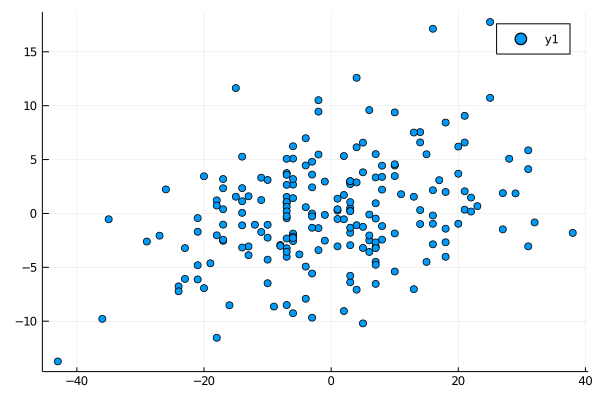

In [132]:
train_pred = train_x_ppg*w_ppg
test_pred = test_x_ppg*w_ppg

train_MSE = MSE(train_y, train_pred)
test_MSE = MSE(test_y, test_pred)

println("PPG")
println("Train MSE\t", train_MSE)
println("Test MSE \t", test_MSE)

plot(train_y, train_pred, seriestype = :scatter)

PPG and Takeaways
Train MSE	175.93448967455208
Test MSE 	218.75730776171432


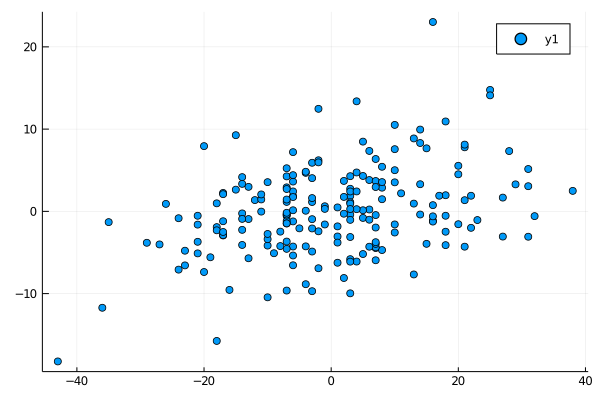

In [133]:
train_pred = train_x_small*w_small
test_pred = test_x_small*w_small

train_MSE = MSE(train_y, train_pred)
test_MSE = MSE(test_y, test_pred)

println("PPG and Takeaways")
println("Train MSE\t", train_MSE)
println("Test MSE \t", test_MSE)

plot(train_y, train_pred, seriestype = :scatter)

Train MSE	150.9792117990954
Test MSE 	233.76298853409108


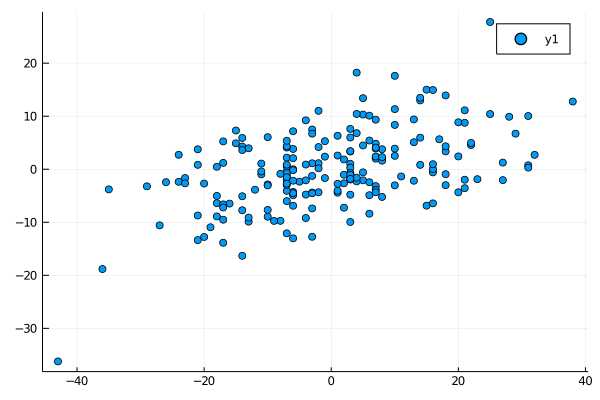

In [134]:
train_pred = train_x*w
test_pred = test_x*w

train_MSE = MSE(train_y, train_pred)
test_MSE = MSE(test_y, test_pred)

println("Train MSE\t", train_MSE)
println("Test MSE \t", test_MSE)

plot(train_y, train_pred, seriestype = :scatter)

In [131]:
#testing regressions on a late week, low point dif game
n = 28
n = 20
test_game = convert(Array,test[n,5:end])
X_game = append!(test_game, 1)
X_game_ppg = [test[n,:HomePtsPG] test[n,:AwayPtsPG] 1]
X_game_small = [X_game_ppg[1:2]' test[n,:HomeTakeawaysPG] test[n,:AwayTakeawaysPG] 1]

actual = test[n,:PointDif]
pred_ppg_arr = X_game_ppg*w_ppg #this comes out as an array for some reason
pred_ppg = pred_ppg_arr[1]
pred_small = X_game_small*w_small
pred = X_game'*w

println("Actual: $actual")
println("PPG: $pred_ppg")
println("Small: $pred_small")
println("Full: $pred")

Actual: 4.0
PPG: -12.008662367892825
Small: -19.808479182003886
Full: -25.22836258149147


In [44]:
hTeam = "Bills"
aTeam = "Seahawks"
h_2020_ppg = 24.8
h_2020_ta = 10/8
a_2020_ppg = 34.3
a_2020_ta = 14/7
X = [h_2020_ppg a_2020_ppg h_2020_ta a_2020_ta 1]
pd = X*w
print("The $hTeam will outscore the $aTeam by $pd points.")

The Bills will outscore the Seahawks by [-6.664648729333212] points.

In [374]:
hTeam = "Jets"
aTeam = "Patriots"
h_2020_ppg = 11.8
a_2020_ppg = 19.4
X = [h_2020_ppg a_2020_ppg 1]
pd = X*w
print("The $hTeam will outscore the $aTeam by $pd points.")

The Jets will outscore the Patriots by [-3.6037246779832084] points.

In [6]:
# # now let's create some DataFrame variables
# cardinals_19 = CSV.read(team_names_split[1,2])
# falcons_19 = CSV.read(team_names_split[2,2])
# ravens_19 = CSV.read(team_names_split[3,2])
# bills_19 = CSV.read(team_names_split[4,2])
# panthers_19 = CSV.read(team_names_split[5,2])
# bears_19 = CSV.read(team_names_split[6,2])
# bengals_19 = CSV.read(team_names_split[7,2])
# browns_19 = CSV.read(team_names_split[8,2])
# cowboys_19 = CSV.read(team_names_split[9,2])
# broncos_19 = CSV.read(team_names_split[10,2])
# lions_19 = CSV.read(team_names_split[11,2])
# packers_19 = CSV.read(team_names_split[12,2])
# texans_19 = CSV.read(team_names_split[13,2])
# colts_19 = CSV.read(team_names_split[14,2])
# jaguars_19 = CSV.read(team_names_split[15,2])
# chiefs_19 = CSV.read(team_names_split[16,2])
# dolphins_19 = CSV.read(team_names_split[17,2])
# vikings_19 = CSV.read(team_names_split[18,2])
# patriots_19 = CSV.read(team_names_split[19,2])
# saints_19 = CSV.read(team_names_split[20,2])
# giants_19 = CSV.read(team_names_split[21,2])
# jets_19 = CSV.read(team_names_split[22,2])
# raiders_19 = CSV.read(team_names_split[23,2])
# eagles_19 = CSV.read(team_names_split[24,2])
# steelers_19 = CSV.read(team_names_split[25,2])
# chargers_19 = CSV.read(team_names_split[26,2])
# # note: name different than csv file name
# fortyniners_19 = CSV.read(team_names_split[27,2])
# seahawsks_19 = CSV.read(team_names_split[28,2])
# rams_19 = CSV.read(team_names_split[29,2])
# buccaneers_19 = CSV.read(team_names_split[30,2])
# titans_19 = CSV.read(team_names_split[31,2])
# redskins_19 = CSV.read(team_names_split[32,2])
# teams = []
# # for i in 1:32
# #     teams[i] = CSV.read(team_names_split[i,2])

LoadError: syntax: "%" is not a unary operator

In [304]:
# n = size(final)[1]

# pats4 = copy(final[8,:])

# mult = 1
# if pats4[:isHome] == "0"
#     mult = -1
#     awayID = pats4[:Team]
#     homeID = pats4[:Opponent]
# else
#     homeID = pats4[:Team]
#     awayID = pats4[:Opponent]
# end

# ptsdif = mult*(pats4[:Tm] - pats4[:Opp_1])

# week = pats4[:Week]

# teamID = pats4[:Team]
# oppID = pats4[:Opponent]

# homeData = filter(row -> row[:Team] == homeID, final);
# homeData = filter(row -> row[:Week] in 1:(week-1), homeData);
# awayData = filter(row -> row[:Team] == awayID, final);
# awayData = filter(row -> row[:Week] in 1:(week-1), awayData);

# wins = sign.(homeData[:,:Tm] .- homeData[:,:Opp_1])
# wins[wins .== -1] .= 0
# homeWinPercent = mean(wins)

# awins = sign.(awayData[:,:Tm] .- awayData[:,:Opp_1])
# awins[awins .== -1] .= 0
# awayWinPercent = mean(awins)

# homePPG = mean(homeData[:Tm])
# awayPPG = mean(awayData[:Tm])

# home1stD = mean(homeData[Symbol("1stD")])
# away1stD = mean(awayData[Symbol("1stD")])

# homeRushPG = mean(homeData[:RushY])
# awayRushPG = mean(awayData[:RushY])

# homePassPG = mean(homeData[:PassY])
# awayPassPG = mean(awayData[:PassY])

# homeTOPG = mean(homeData[:TO])
# awayTOPG = mean(awayData[:TO])

# homePPGAllowed = mean(homeData[:Opp_1])
# awayPPGAllowed = mean(awayData[:Opp_1])

# home1stDAllowed = mean(homeData[Symbol("1stD_1")])
# away1stDAllowed = mean(awayData[Symbol("1stD_1")])

# homeRushPGAllowed = mean(homeData[:RushY_1])
# awayRushPGAllowed = mean(awayData[:RushY_1])

# homePassPGAllowed = mean(homeData[:PassY_1])
# awayPassPGAllowed = mean(awayData[:PassY_1])

# homeTakeawaysPG = mean(homeData[:TO_1])
# awayTakeawaysPG = mean(awayData[:TO_1])
# # final[final[:Week] .< week, :]

0.8571428571428571